## 🏠 House Prices - Random Forest

Os modelos Random Forest Regressor são utilizados para capturar relações não lineares e interações complexas entre as variáveis. Por serem modelos baseados em árvores não assumem linearidade e são robustos a outliers;

### Destaques do Notebook  

* **Pré-processamento inicial:** leitura dos dados e remoção de colunas com mais de 10% de valores ausentes, garantindo um conjunto de treino consistente e sem variáveis excessivamente incompletas.

* **Transformação das variáveis:** aplicação de imputação por mediana e padronização nas variáveis numéricas, enquanto as categóricas são convertidas via One-Hot Encoding. Todo o fluxo é integrado em um único ColumnTransformer para assegurar coerência durante treino e inferência.

* **Treinamento do modelo:** construção de um pipeline com o RandomForest,sem ajustes hiperparâmetros e com ajuste. O modelo é treinado utilizando a variável alvo em escala logarítmica para maior estabilidade e desempenho preditivo.

---


## 1. Bibliotecas

In [1]:
# =====================================================
# 🏠 House Prices - Random Forest 
# =====================================================
import pandas as pd

# Scikit-learn - Modelos ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from pathlib import Path
from setup_notebook import setup_path
setup_path()
from src.model_utils import *
import joblib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## 2. Dataload & preprocessamento

In [2]:
BASE = Path.cwd().parent   
# =====================================================
# ⚙️ 0. carregamento dos preprocessador 
# =====================================================
temp = joblib.load(BASE /'src'/'preprocess_HP_v1.joblib')
preprocessador=temp['preprocessador']
colnull_train = temp['colnull_train']


# =====================================================
# 📁 1. Leitura dos dados & Separação das bases
# =====================================================
DATA_DIR = BASE / "data" / "raw"
X_train = pd.read_csv(DATA_DIR / "X_train_raw.csv")
X_test  = pd.read_csv(DATA_DIR / "X_test_raw.csv")
y_train = pd.read_csv(DATA_DIR / "y_train_raw.csv")
y_test  = pd.read_csv(DATA_DIR / "y_test_raw.csv")

# =====================================================
#  🤖 3.Modelos
# =====================================================
DATA_MODELS= BASE /"models"

RF0=joblib.load(DATA_MODELS / 'modelo_RF0_final_v1.joblib') #baseline
RF1=joblib.load(DATA_MODELS / 'modelo_RF1_final_v1.joblib')


### 3.Treinamento
### 3.1 Random Forest (baseline) 

In [3]:
# 1. Valida a estabilidade 
r20 = valida(X_train, y_train, model=RF0, N=7)

# 2. Testa a performance 
RF0.fit(X_train, y_train)
y_pred = RF0.predict(X_test)
res0 = metricas_model(y_test, y_pred, 'Random Forest Regressor 0')

Validação cruzada realizada!


**Comentários**
Utiliza os hiperparâmetros padrão do scikit-learn, servindo como baseline não linear 

### 3.2 Random Forest tunned


In [4]:
# 1. Valida a estabilidade 
r21 = valida(X_train, y_train, model=RF1, N=7,write='on')

# 2. Testa a performance 
RF1.fit(X_train, y_train)
y_pred = RF1.predict(X_test)
res1 = metricas_model(y_test, y_pred, 'Random Forest Regressor 1',write='on')

validação cruzada (K-Fold Cross Validation)
Fold 1: R² = 0.8659
Fold 2: R² = 0.8838
Fold 3: R² = 0.8668
Fold 4: R² = 0.8454
Fold 5: R² = 0.9009
Fold 6: R² = 0.8484
Fold 7: R² = 0.8596

📊 R² médio: 0.8673 ± 0.0181
🤖 RANDOM FOREST REGRESSOR 1
MAE:   0.0919
RMSE: 0.1383
R²:   0.8872


**Comentários**
* Modelo com ajuste explícito de hiperparâmetros, visando melhor compromisso entre viés,variância ecusto computacional.
* Controle do overfitting via limitação da profundidade (max_depth=25)
* Melhor generalização tanto pelo max_features=03. como bootstrap ativa.

,Modelo,MAE,RMSE,R²
0,Random Forest Regressor 0,0.0934,0.1382,0.8874
1,Random Forest Regressor 1,0.0919,0.1383,0.8872


,Modelo,R2_Médio,R2_Std
0,RF0,0.854492,0.024164
1,RF1,0.867258,0.018131


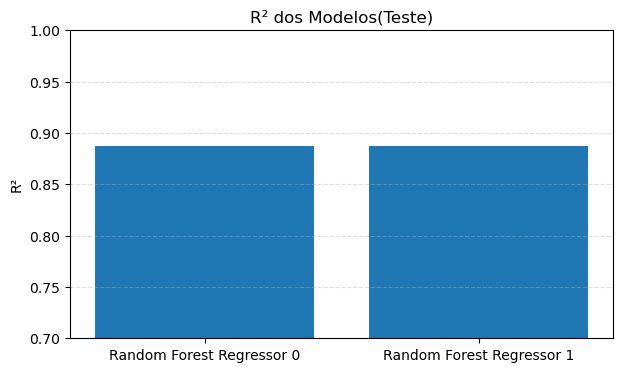

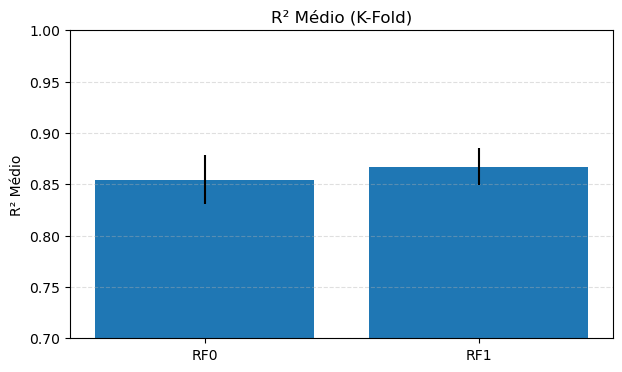

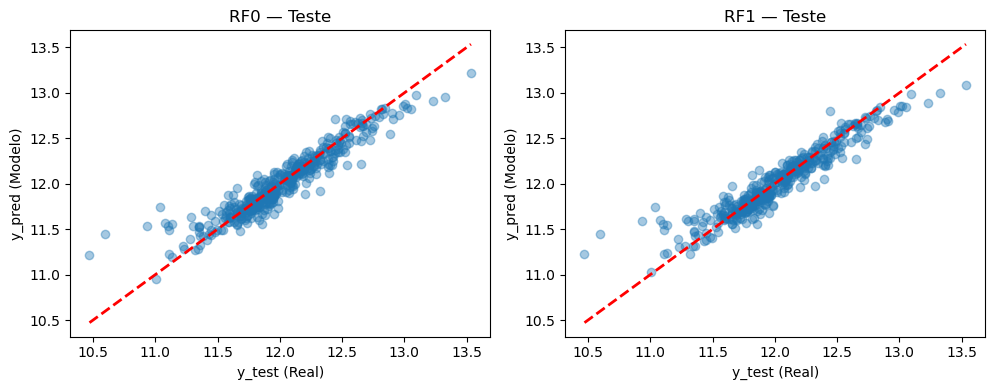

In [5]:
# =====================================================
# 1. Organizar resultados em DataFrame
# =====================================================

resultados_teste = pd.DataFrame([
    res0, res1])

resultados_cv = pd.DataFrame({
    "Modelo": ["RF0", "RF1"],
    "R2_Médio": [np.mean(r20), np.mean(r21),],
    "R2_Std":   [np.std(r20),  np.std(r21)]
})

display(resultados_teste)
display(resultados_cv)

# =====================================================
# 2. Gráfico — R² no conjunto de teste
# =====================================================

plt.figure(figsize=(7,4))
plt.bar(resultados_teste['Modelo'], resultados_teste['R²'])
plt.title("R² dos Modelos(Teste)")
plt.ylabel("R²")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# =====================================================
# 3. Gráfico — R² médio da validação cruzada
# =====================================================

plt.figure(figsize=(7,4))
plt.bar(resultados_cv['Modelo'], resultados_cv['R2_Médio'], yerr=resultados_cv['R2_Std'])
plt.title("R² Médio (K-Fold)")
plt.ylabel("R² Médio")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# =====================================================
# 4. Gráfico de Dispersão — y_test vs y_pred para cada modelo
# =====================================================

predicoes = {
    "RF0": RF0.predict(X_test),
    "RF1": RF1.predict(X_test)

}

plt.figure(figsize=(15,4))

for i, (nome, y_p) in enumerate(predicoes.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_p, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
    plt.title(f"{nome} — Teste")
    plt.xlabel("y_test (Real)")
    plt.ylabel("y_pred (Modelo)")

plt.tight_layout()
plt.show()

---

## 4. Considerações Finais

### Síntese dos resultados

Ambos os modelos Random Forest apresentam **RMSE ≈ 0.138** e **R² ≈ 0.887**, valor superior aos modelos lineares simples. A diferença entre RF0 e RF1 em termos de erro é pequena, indicando:saturação de desempenho e limitação imposta pela qualidade dos atributos e não pela capacidade do modelo.

### Estabilidade (validação cruzada)

O RF1 apresenta:**maior R² médio (0.867)** e **menor desvio padrão (≈ 0.018)** indicando: 
  * melhor estabilidade entre diferentes partições;
  * menor sensibilidade à amostra de treino;
  * maior robustez para generalização.

Os resultados confirmam que modelos baseados em árvores capturam com eficiência a estrutura não linear do problema, superando abordagens puramente lineares em termos de desempenho absoluto. No entanto:

* O ganho em relação ao **Ridge otimizado** é marginal;
* O custo computacional e a menor interpretabilidade devem ser considerados;
* O RF1 se destaca como o modelo **mais estável**, embora não significativamente mais preciso.

### Conclusão prática

* **Random Forest ajustado (RF1)** é recomendado quando:
  * o objetivo principal é desempenho e robustez;
  * interpretabilidade não é crítica.
* **Ridge Regression** permanece altamente competitivo pela simplicidade e interpretabilidade e menor custo computacional, mesmo que este não seja uma atributo aqui mensurado, deve ser levar em consideração na escalabilidade.
